In [1]:
import torch
from models.gspnp.lightning_GSDRUNet import StudentGrad

In [2]:
model=StudentGrad(network='unet',numInChan=3,numOutChan=3)

In [3]:
model.model.load_state_dict(torch.load('miscs/unet.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
from PIL.Image import open as imopen
import numpy as np

In [8]:
X=torch.tensor(np.asarray(imopen('/export1/project/zihao/data/CBSD68/test/105025.png')),dtype=torch.float32,device='cpu')[:256,:256,:]

In [11]:
X=X.permute(2,0,1).unsqueeze(0)

In [12]:
X.shape

torch.Size([1, 3, 256, 256])

In [13]:
import matplotlib.pyplot as plt

In [18]:
X=X/255.

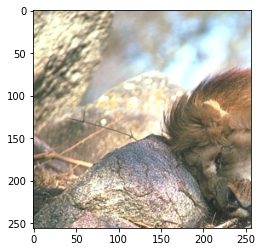

In [19]:
plt.imshow(X[0,:,:,:].detach().permute(1,2,0).numpy())

In [28]:
Xblur=X+torch.FloatTensor(X.size()).normal_(mean=0, std=7.65/255.).to(X.device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


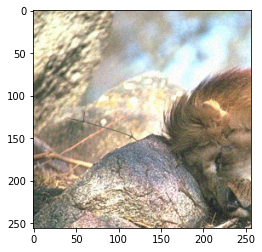

In [29]:
plt.imshow(Xblur[0,:,:,:].detach().permute(1,2,0).numpy())

In [30]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [31]:
psnr(X[0,:,:,:].detach().permute(1,2,0).numpy(),Xblur[0,:,:,:].detach().permute(1,2,0).numpy())

30.44028644302933

In [32]:
Xdenoise=Xblur-model.grad(Xblur,7.65/255.,False)

In [33]:
psnr(X[0,:,:,:].detach().permute(1,2,0).numpy(),Xdenoise[0,:,:,:].detach().permute(1,2,0).numpy())

37.0585575777737